<p style="background:#003F7D; color:white; font-size: 2.1em; text-align:center"> 
    <br><br><b> Podcast Reviews </b><br><br><br>
</p>

<p style="text-align: right;">Module 2: Data Analysis<br>
Sprint 2: Inferential Statistical Analysis<br>
Author : Renato Mariano</p>

<h1 style="color:#003F7D">Introduction </h1>

This project is based on a Podcast Reviews dataset from Kagle. The scraped data is available on https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28.

The data consists in 2 million podcast reviews for 100k podcasts.

The scope of this project includes:

- Perform queries on the data using SQL.
- Perform Exploratory Data Analysis (EDA).
- Apply statistical inference procedures.
- Create Dashbord and Graphs to visualize and present the data.

<h2 style="color:#003F7D">Library Imports and Notebook Setup </h2>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
# Notebook setup
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML      # center plots in the notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
def clear_boxplot(ax, plot_title="", plot_xlabel="", plot_ylabel="", legend_visibility=False):
    '''Remove unnecessary content from a boxplot / violinplot'''

    ax.set(xlabel=plot_xlabel, ylabel=plot_ylabel)
    ax.set_title(plot_title, fontsize=14, color='#010048')

    ax.tick_params(
        axis="both",
        which="both",
        length=0,
    )
    
    if not legend_visibility:
        ax.legend([],frameon=legend_visibility)
        
    ax.set_xticklabels([])

In [4]:
def clear_histplot(ax, plot_title="", plot_xlabel="", plot_ylabel="", legend_visibility=False):

    ax.set(xlabel=plot_xlabel, ylabel=plot_ylabel, title=plot_title)
    ax.set_title(plot_title, color='#010048', fontsize=14)
    ax.tick_params(axis="both", which="both", length=0)  
    
    if not legend_visibility:
        ax.legend([],frameon=legend_visibility)

<h1 style="color:#003F7D">Dataset Overview </h1>

**<p style="color:#003F7D; font-size: 1.1em">Tables available in the dataset</p>**

In [5]:
def select_all_columns(table_name):
    '''General query for output of all of the columns of a dataframe in the database'''
    query = f"SELECT * FROM {table_name};"
    return query

In [6]:
# Connect to the SQLite database
con = sqlite3.connect("db_podcast_reviews.sqlite")

# checking the database tables
table = pd.read_sql(select_all_columns("sqlite_master WHERE type='table'"), con)

In [7]:
table.head()

,type,name,tbl_name,rootpage,sql
0,table,runs,runs,2,CREATE TABLE runs (\n run_at text not n...
1,table,podcasts,podcasts,3,CREATE TABLE podcasts (\n podcast_id te...
2,table,categories,categories,5,CREATE TABLE categories (\n podcast_id ...
3,table,reviews,reviews,7,CREATE TABLE reviews (\n podcast_id tex...


The database is made out of 4 dataframes, one of them (runs) includes only the date when the author included new reviews to the dataset.

**<p style="color:#003F7D; font-size: 1.1em">Features of the dataset</p>**

In [8]:
podcasts = pd.read_sql(select_all_columns("podcasts"), con)
categories = pd.read_sql(select_all_columns("categories"), con)
reviews = pd.read_sql(select_all_columns("reviews"), con)

# The table "runs" will not be part in the evaluation; code left only for showing the DF to reviewer
#runs = pd.read_sql(select_all_columns("runs"), con)

In [9]:
podcasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110024 entries, 0 to 110023
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   podcast_id  110024 non-null  object
 1   itunes_id   110024 non-null  int64 
 2   slug        110024 non-null  object
 3   itunes_url  110024 non-null  object
 4   title       110024 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.2+ MB


Two columns present good possibilities for further evaluation and link to other columns, the Primary_key: 'podcast_id' and the 'title'.

In [10]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212372 entries, 0 to 212371
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   podcast_id  212372 non-null  object
 1   category    212372 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


This one only separates the categories into a different dataframe.

In [11]:
reviews.head()

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00


In [12]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067529 entries, 0 to 2067528
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   podcast_id  object
 1   title       object
 2   content     object
 3   rating      int64 
 4   author_id   object
 5   created_at  object
dtypes: int64(1), object(5)
memory usage: 94.6+ MB


The reviews dataframe contains the author, rating, content and post time for each review of each podcast.

In [13]:
print(f"An average rating of {reviews['rating'].mean():.3f} is presented in the whole dataset")

An average rating of 4.627 is presented in the whole dataset


The following cell shows how the podcasts are distributed in the different categories. 

It is to observe that the **greatest number of podcasts** fall into the category **"society-culture"**, followed by **"education"** and **"comedy"**.

In [14]:
categories.groupby('category').size().sort_values(ascending=False)

category
society-culture          18710
education                12628
comedy                   12464
religion-spirituality    12190
business                 12058
                         ...  
sports-swimming             18
science-physics             18
science-chemistry           17
science-mathematics         16
sports-volleyball           14
Length: 110, dtype: int64

<h1 style="color:#003F7D">Research Question </h1>

After an evaluation of the data, the following reaserch question will be used as goal of this analysis.

<p style="color:#003F7D; font-size: 1.1em; text-align: center; background:#eaf4ff; color:#003F7D">"Are there significant differences in ratings between the top two categories with the highest number of podcasts, namely 'society-culture' and 'education'?" </p>

<h1 style="color:#003F7D">Data Preparation </h1>

Let's start the preparation of the data by merging the title and categories with the reviews.

In [15]:
# rename 'title' column in podcasts for future merge
podcasts.rename(columns={'title': 'podcast_title'}, inplace=True)

In [16]:
# Merge podcast title
reviews_podcast = reviews.merge(podcasts[['podcast_id', 'podcast_title']], on='podcast_id', how='left')

# Merge categories, 1 podcast can be classified in different categories
categories_dict = categories.groupby('podcast_id')['category'].agg(list).to_dict()
reviews_podcast['categories'] = reviews_podcast['podcast_id'].map(categories_dict)

In [17]:
reviews_podcast.head()

,podcast_id,title,content,rating,author_id,created_at,podcast_title,categories
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00,Backstage at Tilles Center,"[arts, arts-performing-arts, music]"
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00,Backstage at Tilles Center,"[arts, arts-performing-arts, music]"
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00,TED Talks Daily,"[arts, arts-design, education, society-culture]"
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00,TED Talks Daily,"[arts, arts-design, education, society-culture]"
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00,TED Talks Daily,"[arts, arts-design, education, society-culture]"


In [18]:
# Verification of the merging process
print(f'The number of rows of reviews is the same as reviews_podcast: {reviews_podcast.shape[0] == reviews.shape[0]}')

The number of rows of reviews is the same as reviews_podcast: True


In [19]:
# Did some of the authors publish a lot of comments?
reviews_podcast.groupby('author_id').size().sort_values(ascending=False)

author_id
791F376ACA3C08D    615
D3307ADEFFA285C    615
96A3F0358E7808D    475
04C3B6DEFE22FB1    433
8858ED4249110B6    399
                  ... 
5E32C6CDF93BB77      1
5E32B43F5F49AB3      1
5E32AF97EC3F02D      1
5E328E090DA4919      1
FFFFF7639CED0A6      1
Length: 1475285, dtype: int64

It is suspectifull that 1 user had posted more than 615 comments. Let's investigate further!

<h2 style="color:#003F7D">Bots Identification</h2>

The initial idea was to make a groupby only by "author_id" and "podcast_id", but some people can indeed leave more than one review for a podcast in a spaced time frame.

To be more sure the "created_at" column (without time) was also grouped.

In [20]:
# Convert 'created_at' column to datetime type
reviews_podcast['created_at'] = pd.to_datetime(reviews_podcast['created_at'])

In [21]:
# Group the repeated reviews of the same author for 1 podcast in 1 day
grouped_reviews_podcast = (
    reviews_podcast.groupby(["author_id", "podcast_id", "podcast_title", pd.Grouper(key='created_at', freq='D')])
    .agg(average_rating=("rating", "mean"), count=("rating", "size"))
    .sort_values(by="count", ascending=False)
    .reset_index()
)

# Add the categories to associated to each podcast_id
grouped_reviews_podcast['categories'] = grouped_reviews_podcast['podcast_id'].map(categories_dict)
grouped_reviews_podcast.head()

,author_id,podcast_id,podcast_title,created_at,average_rating,count,categories
0,638AB2A1FAD6645,cb32c9f3c108d06349a72f2ad56fc3f4,Raider Power Podcast,2018-09-11 00:00:00-07:00,5.0,40,"[sports, sports-basketball, sports-football]"
1,D5B2B52C3CD80F8,b34801afb33a9076b211f0c261b3d72e,iNTO THE FRAY RADIO - An Encounter with the Ab...,2018-09-09 00:00:00-07:00,5.0,38,[science]
2,D02C95E0FC00426,c22c8ca2cb8dcd50c3d889ba17de8087,Mitchum | Tales of a Moonshine Bootlegger in G...,2018-09-10 00:00:00-07:00,5.0,24,"[society-culture, society-culture-personal-jou..."
3,BAC4454D7D50CEB,ecf4a9caf3835a660f83edfa27d57af1,Mary English Astrologer Blog,2018-09-06 00:00:00-07:00,5.0,24,"[religion-spirituality, society-culture, spiri..."
4,2AA5C9E5F647668,a7937ef8ee6043959d9f0ce436b062b5,DnDnD,2018-09-07 00:00:00-07:00,5.0,18,"[comedy, fiction, fiction-comedy-fiction]"


As one can see, for "Raider Power Podcast" 1 user published about 40 comments in 1 day.

When the date is excluded from the grouping, the values get to 79 ratings from the same user to 1 podcast ("The Daily").

The data will be cleaned considering that a bot/flood reviews happened by any count higher than 2.

In [22]:
bot_authors = grouped_reviews_podcast['author_id'][grouped_reviews_podcast['count'] > 2].unique()

In [23]:
filtered_reviews = reviews_podcast[~reviews_podcast['author_id'].isin(bot_authors)]

In [24]:
print(
    f"The identified bots represent {100*(reviews_podcast.shape[0] - filtered_reviews.shape[0])/reviews_podcast.shape[0]:.3f}% of the data"
)
print(
    f"The identified bots represent {(reviews_podcast.shape[0] - filtered_reviews.shape[0])} rows of the data"
)

The identified bots represent 0.032% of the data
The identified bots represent 671 rows of the data


As shown, it is not expected that the global average rating for podcasts will change with these bots (too small proportion of the data).

The filtered data will be used as base for further exploration.

In [25]:
filtered_reviews.head()

,podcast_id,title,content,rating,author_id,created_at,podcast_title,categories
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24 12:05:16-07:00,Backstage at Tilles Center,"[arts, arts-performing-arts, music]"
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09 18:14:32-07:00,Backstage at Tilles Center,"[arts, arts-performing-arts, music]"
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11 14:53:39-07:00,TED Talks Daily,"[arts, arts-design, education, society-culture]"
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31 13:08:09-07:00,TED Talks Daily,"[arts, arts-design, education, society-culture]"
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19 13:56:05-07:00,TED Talks Daily,"[arts, arts-design, education, society-culture]"


<h1 style="color:#003F7D">Data Exploration </h1>

<h2 style="color:#003F7D">Categories</h2>

Let's start by making a SQL query to have the average rating and the number of reviews for each category, from the original dataset.

In [26]:
query = """SELECT  c.category,
                    AVG(r.rating) AS avg_rating_original, 
                    COUNT(*) AS total_reviews_original
         FROM reviews r
         JOIN categories c
         ON r.podcast_id=c.podcast_id 
         GROUP BY 1 
         ORDER BY 2 DESC;"""

category_stats = pd.read_sql(query, con)
category_stats.head(8)

,category,avg_rating_original,total_reviews_original
0,sports-rugby,4.988024,167
1,business-marketing,4.937095,28869
2,business-entrepreneurship,4.908377,80242
3,business-non-profit,4.901167,2570
4,sports-swimming,4.892308,130
5,sports-running,4.891993,6157
6,business-careers,4.890061,53921
7,science-chemistry,4.882716,162


In [27]:
category_stats.describe()

,avg_rating_original,total_reviews_original
count,110.000000,110.000000
mean,4.695710,41177.118182
std,0.174850,68781.039431
min,3.965203,84.000000
25%,4.612307,5876.500000
50%,4.752511,17769.000000
75%,4.817755,38433.000000
max,4.988024,441874.000000


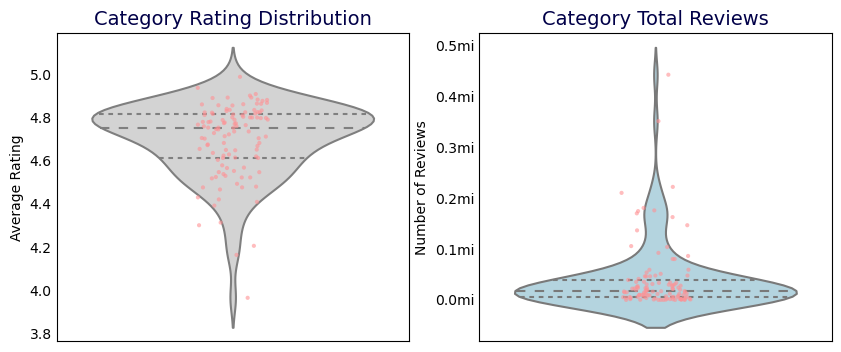

In [28]:
# Violinplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.violinplot(
    y=category_stats["avg_rating_original"],
    inner="quartile",
    linewidth=1.5,
    color="lightgrey",
    ax=ax1,
)
sns.stripplot(
    y=category_stats["avg_rating_original"], size=3, color="#ff9194", alpha=0.6, ax=ax1
)

sns.violinplot(
    y=category_stats["total_reviews_original"],
    inner="quartile",
    linewidth=1.5,
    color="lightblue",
    ax=ax2,
)
sns.stripplot(
    y=category_stats["total_reviews_original"], size=3, color="#ff9194", alpha=0.6, ax=ax2,
)

ylabels = ['{:,.1f}'.format(y) + 'mi' for y in ax2.get_yticks()/1_000_000]
ax2.set_yticklabels(ylabels)

clear_boxplot(ax1, "Category Rating Distribution", plot_ylabel="Average Rating")
clear_boxplot(ax2, "Category Total Reviews", plot_ylabel="Number of Reviews")

As shown in through the statistics and supported through the graphs, the median of the reviews per category is 4.75.

Most of the categories are very well rated. The minimal rating found in a category is 3.96.

The difference between the mean and median in the total reviews indicates a that the distribution is not normal. Let's take a look into that.

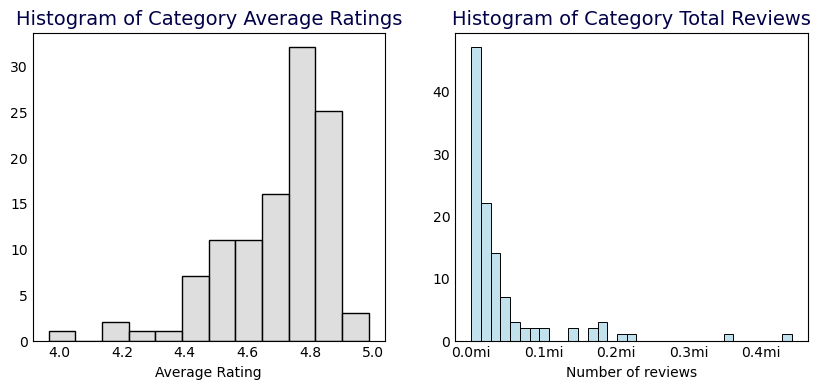

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(category_stats["avg_rating_original"], kde=False, color='lightgrey', ax=ax1)
clear_histplot(ax1, "Histogram of Category Average Ratings", plot_xlabel="Average Rating")

sns.histplot(category_stats["total_reviews_original"], kde=False, color='lightblue', ax=ax2)
xlabels = ['{:,.1f}'.format(x) + 'mi' for x in ax2.get_xticks()/1_000_000]
ax2.set_xticklabels(xlabels)

clear_histplot(ax2, "Histogram of Category Total Reviews", plot_xlabel="Number of reviews")

As commented before, the distribution of the reviews is skewed to the right. This skeweness effect could be decreased by removing the outliers, though the data would still be right skewed.

<h2 style="color:#003F7D">Target categories</h2>

Now we can take a look at our target categories.

In [30]:
category_stats[category_stats['category'].isin(['society-culture','education'])]

,category,avg_rating_original,total_reviews_original
29,education,4.813994,221831
88,society-culture,4.546984,441874


As we can see, there is a difference in the average ratings for the desired categories. Is this difference significant? 

How much impact did the removal of bot authors impacted these categories?

To answer to the second question, we will create a table that contains both these statistics for the original values and the ones after data cleaning.

In [31]:
# Split the categories into separate rows
filtered_reviews_exploded = filtered_reviews.explode("categories")

# Average rating and total reviews for each category - cleaned data
category_stats_filtered = (
    filtered_reviews_exploded.groupby("categories")
    .agg({"rating": "mean", "podcast_id": "count"})
    .reset_index()
    .rename(columns={"categories": "category", "rating": "avg_rating_filtered", "podcast_id": "total_reviews_filtered"})
    .sort_values("avg_rating_filtered", ascending=False)
)
category_stats_filtered.head(8)

,category,avg_rating_filtered,total_reviews_filtered
94,sports-rugby,4.988024,167
13,business-marketing,4.937071,28858
10,business-entrepreneurship,4.908345,80214
14,business-non-profit,4.901129,2569
97,sports-swimming,4.892308,130
95,sports-running,4.891993,6157
9,business-careers,4.890219,53889
71,science-chemistry,4.882716,162


In [32]:
# Merge of original and filtered statistics
category_stats_filtered = category_stats_filtered.merge(category_stats, on='category', how='left')

# Compute of difference in average ratings and in total number of reviews. 
category_stats_filtered["avg_rating_diff"] = (
    category_stats_filtered["avg_rating_filtered"] - category_stats_filtered["avg_rating_original"]
)

category_stats_filtered["total_reviews_diff"] = (
    category_stats_filtered["total_reviews_filtered"] - category_stats_filtered["total_reviews_original"]
)

In [33]:
# Sort the data
category_stats_filtered = category_stats_filtered.sort_values(
    by="total_reviews_diff", ascending=True
)

# Show the data for categories where the rating change is higher than 0.01
category_stats_filtered[
    (category_stats_filtered["avg_rating_diff"] > 0.01)
    | (category_stats_filtered["avg_rating_diff"] < -0.01)
]

,category,avg_rating_filtered,total_reviews_filtered,avg_rating_original,total_reviews_original,avg_rating_diff,total_reviews_diff


In [34]:
category_stats_filtered

,category,avg_rating_filtered,total_reviews_filtered,avg_rating_original,total_reviews_original,avg_rating_diff,total_reviews_diff
88,society-culture,4.546932,441724,4.546984,441874,-5.196096e-05,-150
17,business,4.839395,209987,4.839410,210081,-1.474139e-05,-94
29,education,4.814051,221738,4.813994,221831,5.728111e-05,-93
81,sports,4.612139,175617,4.612251,175709,-1.120217e-04,-92
78,comedy,4.623424,350763,4.623424,350848,-2.558821e-08,-85
...,...,...,...,...,...,...,...
71,education-language-learning,4.668225,5347,4.668225,5347,0.000000e+00,0
72,news-entertainment-news,4.654457,23751,4.654457,23751,0.000000e+00,0
76,science-physics,4.635776,464,4.635776,464,0.000000e+00,0
37,sports-cricket,4.797619,84,4.797619,84,0.000000e+00,0


No category had their average rating changed in more than 0.01 due to the bot reviews.

In [35]:
# Show the data for the desided categories
category_stats_filtered[category_stats_filtered['category'].isin(['society-culture','education'])]

,category,avg_rating_filtered,total_reviews_filtered,avg_rating_original,total_reviews_original,avg_rating_diff,total_reviews_diff
88,society-culture,4.546932,441724,4.546984,441874,-0.000052,-150
29,education,4.814051,221738,4.813994,221831,0.000057,-93


For the studied categories this value was only changed minimaly.

<h2 style="color:#003F7D">Statistical significance</h2>

Again our research question:

<p style="color:#003F7D; font-size: 1.1em; text-align: center; background:#eaf4ff; color:#003F7D">"Are there significant differences in ratings between the top two categories with the highest number of podcasts, namely 'society-culture' and 'education'?" </p>

<h3 style="color:#003F7D">Formulating hypothesis</h3>

* Category 1:`'society-culture'`
* Category 2:`'education'`

$$H_0: p_1 = p_2$$
$$H_a: p_1 \ne p_2$$

where $p_1$ and $p_2$ stand for the average rating for the categories society-culture and education, respectively. We'll also set a **confidence level of 95%**:

$$\alpha = 0.05$$

The $\alpha$ value is a threshold we set, by which we say "if the probability of observing a result as extreme or more ($p$-value) is lower than $\alpha$, then we reject the null hypothesis". Since our $\alpha=0.05$ (indicating 5% probability), our confidence (1 - $\alpha$) is 95%.


As our data (rating) is categorical, we will perform a **chi-squared test** to check our hypothesis.

<h3 style="color:#003F7D">Preparing data</h3>

In [36]:
# Separation of the data only for the desired categories
goal_categories = filtered_reviews_exploded[filtered_reviews_exploded['categories'].isin(['society-culture','education'])]
goal_categories.head(5)

,podcast_id,title,content,rating,author_id,created_at,podcast_title,categories
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11 14:53:39-07:00,TED Talks Daily,education
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11 14:53:39-07:00,TED Talks Daily,society-culture
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31 13:08:09-07:00,TED Talks Daily,education
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31 13:08:09-07:00,TED Talks Daily,society-culture
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19 13:56:05-07:00,TED Talks Daily,education


As we see, some of the podcasts belong to both of the chosen categories. To further analyse an avoid effects of one population on the other, we will keep only the podcasts that don't belong to both categories.

In [37]:
# Get all of the podcasts belonging to both categories
duplicated_podcasts = goal_categories[goal_categories['podcast_id'].duplicated()]['podcast_id']

# keep only the ones exclusively belonging to one category
goal_categories_cleaned = goal_categories[~goal_categories['podcast_id'].isin(duplicated_podcasts)]
goal_categories_cleaned.shape

(9038, 8)

In [38]:
goal_categories_cleaned.groupby('categories').size()

categories
education          3652
society-culture    5386
dtype: int64

In [39]:
prop_removed_data1 = goal_categories_cleaned.groupby('categories').size()[0]/goal_categories.groupby('categories').size()[0]
prop_removed_data2 = goal_categories_cleaned.groupby('categories').size()[1]/goal_categories.groupby('categories').size()[1]

print(f"The statistical evaluated data for Category 1 represents {prop_removed_data1*100:.2f}%\n")
print(f"The statistical evaluated data for Category 2 represents {prop_removed_data2*100:.2f}%")

The statistical evaluated data for Category 1 represents 1.65%

The statistical evaluated data for Category 2 represents 1.22%


In [40]:
# stored of the desired data in a simplified dataframe
df1 = goal_categories_cleaned.loc[goal_categories_cleaned['categories'] == 'society-culture', ['podcast_id', 'rating']]
df1.describe()

,rating
count,5386.000000
mean,4.853323
std,0.648994
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [41]:
# stored of the desired data in a simplified dataframe
df2 = goal_categories_cleaned.loc[goal_categories_cleaned['categories'] == 'education', ['podcast_id', 'rating']]
df2.describe()

,rating
count,3652.000000
mean,4.806681
std,0.749969
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [42]:
df1

,podcast_id,rating
11381,ebd3c5a59c3f95d1d0c698bd99280c46,5
12002,ba8281062d196fff796551bc634ea660,5
12521,b468334d4872bf11fd443988a8bd5175,5
12898,e3553a2ec44db21fb4288d31b46e4d94,5
12998,af52d87cdbdaac0f8579cc100a747b6d,5
...,...,...
1868492,ffdf165106c6b77152506b63ad733b54,4
1869078,fffd11eb87de4d586f13627622e4e6dd,5
1869083,ffff09ad9a175a57b1bbbdb3c1581ec0,5
1919195,a8478d40f60e53c206f312351c576037,3


In [43]:
p1 = df1['rating'].mean()
std1 = df1['rating'].std()
n1 = df1.shape[0]
print(f"Category 1 - society-culture: {p1:.3f} +- {std1:.3f}; {n1} samples")
print(f"Rating interval:              ({p1 - std1:.3f} , {5:.3f})\n")

p2 = df2['rating'].mean()
std2 = df2['rating'].std()
n2 = df2.shape[0]
print(f"Category 2 - education: {p2:.3f} +- {std2:.3f}; {n2} samples")
print(f"Rating interval:              ({p2 - std2:.3f} , {5:.3f})\n")
print(f"Best point estimate: {p1-p2:.3f}")

Category 1 - society-culture: 4.853 +- 0.649; 5386 samples
Rating interval:              (4.204 , 5.000)

Category 2 - education: 4.807 +- 0.750; 3652 samples
Rating interval:              (4.057 , 5.000)

Best point estimate: 0.047


The average rating for all the podcast exclusively in the category "society-culture" is 0.047 higher than for the ones exclusively in "education".

<h3 style="color:#003F7D">Assumptions</h3>

The chi-square test evaluates the independence or association between two categorical variables by comparing the observed frequencies in a contingency table to the expected frequencies under the assumption of independence. It is a non-parametric test that is suitable for analyzing categorical data.

For our studied categories, we removed all of the podcasts that belonged to both of the goal categories, so the independancy of the populations can be assumed.

<h3 style="color:#003F7D">Chi-square test</h3>

In [44]:
# Creation of the pivot table for use in the test
cont_table1 = pd.crosstab(index=df1['rating'], columns='count').rename(columns={'count':'count_df1'})
cont_table2 = pd.crosstab(index=df2['rating'], columns='count').rename(columns={'count':'count_df2'})
contingency_table = cont_table1.join(cont_table2)
contingency_table

col_0,count_df1,count_df2
rating,,
1,110,102
2,30,27
3,47,49
4,166,119
5,5033,3355


In [45]:
# Carring out the test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Chi-square statistic: 11.683030803557628
p-value: 0.01987075661836664
Degrees of freedom: 4
Expected frequencies:
 [[ 126.33680018   85.66319982]
 [  33.96791326   23.03208674]
 [  57.20911706   38.79088294]
 [ 169.83956628  115.16043372]
 [4998.64660323 3389.35339677]]


$$p-value = 0.02    <   \alpha = 0.05$$

That means that for out confidence interval of 95% we have enough evidence to reject the null hypothesis ($H_0$).

So **the mean of the categories 'society-culture' and 'education' is statistically different**.

<h2 style="color:#003F7D">Statistical significance with Dependent Data</h2>

Something interesting from this analysis would be to identify the generated results if the intersected data would not have been removed. This is performed as follows.

<h3 style="color:#003F7D">Preparing data</h3>

In [46]:
# So the base for this extra analysis will be the goal_categories data table
goal_categories.head(5)

,podcast_id,title,content,rating,author_id,created_at,podcast_title,categories
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11 14:53:39-07:00,TED Talks Daily,education
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11 14:53:39-07:00,TED Talks Daily,society-culture
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31 13:08:09-07:00,TED Talks Daily,education
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31 13:08:09-07:00,TED Talks Daily,society-culture
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19 13:56:05-07:00,TED Talks Daily,education


In [47]:
goal_categories.groupby('categories').size()

categories
education          221738
society-culture    441724
dtype: int64

In [48]:
# stored of the desired data in a simplified dataframe
df1_dep = goal_categories.loc[goal_categories['categories'] == 'society-culture', ['podcast_id', 'rating']]
df1_dep.describe()

,rating
count,441724.000000
mean,4.546932
std,1.141005
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [49]:
# stored of the desired data in a simplified dataframe
df2_dep = goal_categories.loc[goal_categories['categories'] == 'education', ['podcast_id', 'rating']]
df2_dep.describe()

,rating
count,221738.000000
mean,4.814051
std,0.746890
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [50]:
p1_dep = df1_dep['rating'].mean()
std1_dep = df1_dep['rating'].std()
n1_dep = df1_dep.shape[0]
print(f"Category 1 - society-culture: {p1_dep:.3f} +- {std1_dep:.3f}; {n1_dep} samples")
print(f"Rating interval:              ({p1_dep - std1_dep:.3f} , {5:.3f})\n")

p2_dep = df2_dep['rating'].mean()
std2_dep = df2_dep['rating'].std()
n2_dep = df2_dep.shape[0]
print(f"Category 2 - education: {p2_dep:.3f} +- {std2_dep:.3f}; {n2_dep} samples")
print(f"Rating interval:              ({p2_dep - std2_dep:.3f} , {5:.3f})\n")
print(f"Best point estimate: {p1_dep-p2_dep:.3f}")

Category 1 - society-culture: 4.547 +- 1.141; 441724 samples
Rating interval:              (3.406 , 5.000)

Category 2 - education: 4.814 +- 0.747; 221738 samples
Rating interval:              (4.067 , 5.000)

Best point estimate: -0.267


In [51]:
print(f"The mean value for Category 1 - society-culture changed in : {p1 - p1_dep:.3f}")
print(f"The std value for Category 1 changed in : {std1 - std1_dep:.3f}\n")


print(f"The mean value for Category 2 - education changed in : {p2 - p2_dep:.3f}")
print(f"The std value for Category 1 changed in : {std2 - std2_dep:.3f}")

The mean value for Category 1 - society-culture changed in : 0.306
The std value for Category 1 changed in : -0.492

The mean value for Category 2 - education changed in : -0.007
The std value for Category 1 changed in : 0.003


As shown the dependant data has a much higher standard deviation and lower mean for the category Society-culture.
For education the change in these two parameters is almost irrelevant.

<h3 style="color:#003F7D">Chi-square test</h3>

In [52]:
# Creation of the pivot table for use in the test
cont_table_dep1 = pd.crosstab(index=df1_dep['rating'], columns='count').rename(columns={'count':'count_df1'})
cont_table_dep2 = pd.crosstab(index=df2_dep['rating'], columns='count').rename(columns={'count':'count_df2'})
contingency_table_dep = cont_table_dep1.join(cont_table_dep2)
contingency_table_dep

col_0,count_df1,count_df2
rating,,
1,30232,5882
2,12600,2281
3,13617,2930
4,14169,5001
5,371106,205644


In [53]:
# Carring out the test
chi2, p_value, dof, expected = chi2_contingency(contingency_table_dep)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Chi-square statistic: 10547.568429337849
p-value: 0.0
Degrees of freedom: 4
Expected frequencies:
 [[ 24044.21132785  12069.78867215]
 [  9907.56794511   4973.43205489]
 [ 11016.76814648   5530.23185352]
 [ 12763.12596652   6406.87403348]
 [383992.32661403 192757.67338597]]


$$p-value = 0.00    <   \alpha = 0.05$$

That means would theoretically mean that for the chosen confidence interval of 95% we would have enough evidence to reject the null hypothesis ($H_0$).

**Such an extreme p-value however raises a flag on this extra analysis, highlighting that the proceedure taken initially might be more accurate.**

<h1 style="color:#003F7D">Conclusions </h1>

As demonstrated in the analysis, the average ratings of podcasts in the 'society-culture' and 'education' categories are statistically different. 

Additionally, the analysis revealed the following:
- Reviews conducted by bots account for less than 1% of the total reviews.
- No category had its average rating altered by more than 0.01 as a result of the bot reviews.

The presence of bot reviews in the dataset is minimal and has negligible impact on the average ratings of the categories.
